# process spectra for AuxTel with new spectractor (May 2022) for particular config for Hologram

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : May 20th 2022

- version v3 : Work with exposure butlen gen3


- Config H:

       
       After pull request from Jeremy on git-branch issue-auxteltarget
       
       pour faire simple, je propose une pull request d'une branche qui contient mes réglages vers ta branche issue-auxteltarget :

       https://github.com/LSSTDESC/Spectractor/pull/95
       

This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 




- Creation June 28th 2022

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.path)

['/Users/dagoret/MacOSX/GitHub/LSST/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2022_07', '/Users/dagoret/anaconda3/lib/python39.zip', '/Users/dagoret/anaconda3/lib/python3.9', '/Users/dagoret/anaconda3/lib/python3.9/lib-dynload', '', '/Users/dagoret/anaconda3/lib/python3.9/site-packages', '/Users/dagoret/anaconda3/lib/python3.9/site-packages/aeosa', '/Users/dagoret/anaconda3/lib/python3.9/site-packages/Spectractor-2.1-py3.9.egg', '/Users/dagoret/anaconda3/lib/python3.9/site-packages/astroquery-0.4.7.dev7761-py3.9.egg', '/Users/dagoret/anaconda3/lib/python3.9/site-packages/docopt-0.6.2-py3.9.egg', '/Users/dagoret/anaconda3/lib/python3.9/site-packages/pytz-2022.1-py3.9.egg']


In [3]:
all_paths_to_remove = ['/opt/conda/lib/python3.8/site-packages','/pbs/home/d/dagoret/.local/lib/python3.8/site-packages']

for path_to_remove in all_paths_to_remove:
    if path_to_remove in sys.path:
        print(f"remove {path_to_remove} from sys.path")
        sys.path.remove(path_to_remove)

In [4]:
sys.path

['/Users/dagoret/MacOSX/GitHub/LSST/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2022_07',
 '/Users/dagoret/anaconda3/lib/python39.zip',
 '/Users/dagoret/anaconda3/lib/python3.9',
 '/Users/dagoret/anaconda3/lib/python3.9/lib-dynload',
 '',
 '/Users/dagoret/anaconda3/lib/python3.9/site-packages',
 '/Users/dagoret/anaconda3/lib/python3.9/site-packages/aeosa',
 '/Users/dagoret/anaconda3/lib/python3.9/site-packages/Spectractor-2.1-py3.9.egg',
 '/Users/dagoret/anaconda3/lib/python3.9/site-packages/astroquery-0.4.7.dev7761-py3.9.egg',
 '/Users/dagoret/anaconda3/lib/python3.9/site-packages/docopt-0.6.2-py3.9.egg',
 '/Users/dagoret/anaconda3/lib/python3.9/site-packages/pytz-2022.1-py3.9.egg']

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [6]:
print(sys.executable)
print(sys.version)
#print(sys.version_info)

/Users/dagoret/anaconda3/bin/python
3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]


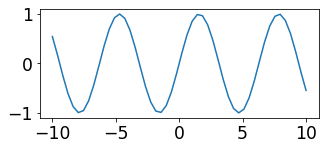

In [7]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               


In [8]:
from iminuit import Minuit
import iminuit

In [9]:
iminuit.__version__

'2.8.4'

In [10]:
from astropy.io import fits
from astropy.coordinates import Angle
from astropy import units as u
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters,dumpfitparameters
from spectractor.extractor.images import *
from spectractor.config import load_config, set_logger
from scipy import ndimage, misc

In [11]:
import logging

In [12]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [13]:
from distutils.dir_util import copy_tree
import shutil

# Configuration

## Logger

In [ ]:
my_logger = logging

## Config for the notebook

In [14]:
version="v5.0"  # version of flipping
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True
FLAG_RUNWITHEXCEPTIONS = False

## Configuration for Spectractor

In [15]:
print("List of configuration files available : ",os.listdir("config"))

List of configuration files available :  ['auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini', 'auxtel_config_holo_DECONVOLUTION_FFM.ini', 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini', 'auxtel_config_ronchi_DECONVOLUTION_PSF1D.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini', 'auxtel_config_holo_DECONVOLUTION_PSF1D.ini', 'auxtel_config_ronchi_DECONVOLUTION_PSF2D.ini', 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini']


In [16]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini']
config_idx = 2
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [17]:
configfilename

'./config/auxtel_config_holo_DECONVOLUTION_FFM.ini'

In [18]:
configdir

'config_DECONVOLUTION_FFM'

In [19]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_FFM.ini


In [20]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


In [21]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /Users/dagoret/anaconda3/lib/python3.9/site-packages/Spectractor-2.1-py3.9.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /Users/dagoret/anaconda3/lib/python3.9/site-packages/Spectractor-2.1-py3.9.egg/spectractor/extractor/dispersers/
DISPLAY True
DISTANCE2CCD 175
DISTANCE2CCD_ERR 0.75
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_PER_MM 350
HALPHA_CENTER 0.0006559
HALPHA_FILTER {'label'

# Exposure config

In [22]:
! ls logbooks

auxtellogbook_BG40~holo4_003_20211104_v5.0.csv
auxtellogbook_BG40~holo4_003_20211104_v5.0.xlsx
auxtellogbook_FELH0600~holo4_003_20211104_v5.0.csv
auxtellogbook_FELH0600~holo4_003_20211104_v5.0.xlsx
auxtellogbook_empty~holo4_003_20211104_v5.0.csv
auxtellogbook_empty~holo4_003_20211104_v5.0.xlsx
auxtellogbook_empty~holo4_003_20220316_v5.0.csv
auxtellogbook_empty~holo4_003_20220316_v5.0.xlsx
auxtellogbook_empty~holo4_003_20220317_v5.0.csv
auxtellogbook_empty~holo4_003_20220317_v5.0.xlsx
auxtellogbook_empty~ronchi170lpmm_20220316_v5.0.csv
auxtellogbook_empty~ronchi170lpmm_20220316_v5.0.xlsx
auxtellogbook_empty~ronchi170lpmm_20220317_v5.0.csv
auxtellogbook_empty~ronchi170lpmm_20220317_v5.0.xlsx


In [23]:
# path index for each month
DATE="20220316"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"

In [24]:
disperser_label = filterdispersername.split("~")[-1]

## Paths

In [25]:
# select if we run at CC or not (locally) 
# /sps/lsst/groups/auxtel/data/2022/holo/20220317
HOSTCC=False
LAPTOP=True

In [26]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
        


In [27]:
path_images

'/Users/dagoret/DATA/AuxTelData2022/data/2022/empty~holo4_003/20220316'

In [28]:
path_topoutput_spectractor

'/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFM'

In [29]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFM/20220316'

# Utility Functions

In [30]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [31]:
!ls logbooks

auxtellogbook_BG40~holo4_003_20211104_v5.0.csv
auxtellogbook_BG40~holo4_003_20211104_v5.0.xlsx
auxtellogbook_FELH0600~holo4_003_20211104_v5.0.csv
auxtellogbook_FELH0600~holo4_003_20211104_v5.0.xlsx
auxtellogbook_empty~holo4_003_20211104_v5.0.csv
auxtellogbook_empty~holo4_003_20211104_v5.0.xlsx
auxtellogbook_empty~holo4_003_20220316_v5.0.csv
auxtellogbook_empty~holo4_003_20220316_v5.0.xlsx
auxtellogbook_empty~holo4_003_20220317_v5.0.csv
auxtellogbook_empty~holo4_003_20220317_v5.0.xlsx
auxtellogbook_empty~ronchi170lpmm_20220316_v5.0.csv
auxtellogbook_empty~ronchi170lpmm_20220316_v5.0.xlsx
auxtellogbook_empty~ronchi170lpmm_20220317_v5.0.csv
auxtellogbook_empty~ronchi170lpmm_20220317_v5.0.xlsx


In [32]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [33]:
filename_logbook

'logbooks/auxtellogbook_empty~holo4_003_20220316_v5.0.csv'

In [34]:
df=pd.read_csv(filename_logbook,index_col=0)

In [35]:
pd.set_option('display.max_rows', None)

In [36]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2022-03-17T01:59:37.776,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600330_postisrccd.fits,330,eta dor,empty_1,holo4_003,1.385409,20.0,...,10.6,44.0,7.2,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2022-03-17T02:00:10.693,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600331_postisrccd.fits,331,eta dor,empty_1,holo4_003,1.386483,20.0,...,10.6,44.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2022-03-17T02:03:04.275,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600337_postisrccd.fits,337,eta dor,empty_1,holo4_003,1.392269,20.0,...,10.6,43.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2022-03-17T02:03:37.365,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600338_postisrccd.fits,338,eta dor,empty_1,holo4_003,1.393378,20.0,...,10.6,43.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2022-03-17T02:06:31.026,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600344_postisrccd.fits,344,eta dor,empty_1,holo4_003,1.399309,20.0,...,10.5,43.0,8.2,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2022-03-17T02:07:03.927,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600345_postisrccd.fits,345,eta dor,empty_1,holo4_003,1.400449,20.0,...,10.5,43.0,7.6,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2022-03-17T02:11:00.681,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600351_postisrccd.fits,351,HD111980,empty_1,holo4_003,1.647734,20.0,...,10.5,43.0,13.1,300.0,1700.0,NaN,NaN,,1.0,1.0
7,7,2022-03-17T02:11:33.581,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600352_postisrccd.fits,352,HD111980,empty_1,holo4_003,1.643280,20.0,...,10.5,43.0,13.1,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2022-03-17T02:14:30.261,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600358_postisrccd.fits,358,HD111980,empty_1,holo4_003,1.619945,20.0,...,10.5,43.0,12.1,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2022-03-17T02:15:03.181,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600359_postisrccd.fits,359,HD111980,empty_1,holo4_003,1.615702,20.0,...,10.5,44.0,6.9,NaN,NaN,NaN,NaN,,NaN,NaN


# Selection of input file
- the input file is selected from the logbook list above

In [37]:
idx=0

In [38]:
print(df.iloc[idx]['file'])

exposure_2022031600330_postisrccd.fits


In [39]:
print(df.iloc[idx])

index                                                          0
date                                     2022-03-17T01:59:37.776
path           /sps/lsst/groups/auxtel/data/2022/empty~holo4_...
file                      exposure_2022031600330_postisrccd.fits
num                                                          330
object                                                   eta dor
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.385409
exposure                                                    20.0
focus                                                   0.041059
seeing                                                  0.921627
pressure                                                  743.55
temperature                                                 10.6
humidity                                                    44.0
windspd                  

In [40]:
myhome=os.getenv("HOME")

In [41]:
dir_images=path_images

In [42]:
dir_images

'/Users/dagoret/DATA/AuxTelData2022/data/2022/empty~holo4_003/20220316'

In [43]:
filename_image=df['file'][idx]
filename_image

'exposure_2022031600330_postisrccd.fits'

In [44]:
target = df['object'][idx]
target

'eta dor'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [45]:
# ## If order 0 position exists in logbook it is selected, otherwise put it by hand

x0=300
y0=1700

if 'Obj-posXpix' in df.columns and 'Obj-posYpix' in df.columns:
    thex0 = df['Obj-posXpix'][idx]
    if not is_nan(thex0):
        x0=thex0
    they0 = df['Obj-posYpix'][idx]
    if not is_nan(they0):
        y0=they0
    
if not is_nan(x0) and not is_nan(y0):

    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

print(f"guess (x0,y0) = ({x0},{y0})")


Order 0 location from logbook : (300,1700)
guess (x0,y0) = (300,1700)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [46]:
rootfilename = filename_image.split(".")[0]
rootfilename_split =  rootfilename.split("_") 
filenumberdir = rootfilename_split[1] 

In [47]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFM/20220316'

In [48]:
configdir

'config_DECONVOLUTION_FFM'

In [49]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
#subdir=filename_image.split(".")[0]
subdir=filenumberdir

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)


# local directories to put spectra and plots
if configdir =="":
    output_directory="./outputs_process_holo"
    output_figures="figures_process_holo"
else:
    output_directory = "./outputs_process_" + filterdispersername + "_" + configdir
    output_figures   = "./figures_process_" + filterdispersername + "_" + configdir
    


guess = [300,1700]

# configuration

config=configfilename    
target=df.iloc[idx]["object"]

In [50]:
print(f"finalpath_output_spectractor = {finalpath_output_spectractor}")
print(f"output_directory = {output_directory}")
print(f"output_figures = {output_figures}")
print(f"config filename = {config}")

finalpath_output_spectractor = /Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFM/20220316/2022031600330
output_directory = ./outputs_process_empty~holo4_003_config_DECONVOLUTION_FFM
output_figures = ./figures_process_empty~holo4_003_config_DECONVOLUTION_FFM
config filename = ./config/auxtel_config_holo_DECONVOLUTION_FFM.ini


In [51]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [52]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
else:
    cleandir(output_directory)
 
# manage subdirs spectrum/ and plots/
if not os.path.isdir(output_figures):
    os.mkdir(output_figures)
else:
    cleandir(output_figures)

# Configuration of the Spectractor running mode

In [53]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [54]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [55]:
target

'eta dor'

## Load the image in the new image file with Spectractor

In [56]:
image=Image(file_name=filename, disperser_label=disperser_label, config=config)

No rebinning: parameters.REBIN is forced to 1.
target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      RA_PREC DEC_PREC ... PM_ERR_MAJA PM_ERR_MINA PM_ERR_ANGLE  Z_VALUE  SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"                     ...   mas / yr    mas / yr      deg                                
----------- ------------- ------------- ------- -------- ... ----------- ----------- ------------ --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635      14       14 ...       0.066       0.061           90 0.0000590                1


In [57]:
image.data.shape

(4072, 4000)

## Show relevant parameters

In [58]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [59]:
image.header["FILTER"]

'empty_1'

In [60]:
image.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2022-03-17T01:59:23.629'                                             
DATE-OBS= '2022-03-17T01:59:23.629'                                             
DATE-BEG= '2022-03-17T01:59:37.776'                                             
DATE-END= '2022-03-17T01:59:58.006'                                             
MJD     =     59655.0829123696                                                  
MJD-OBS =     59655.0830761163                                                  
MJD-BEG =     59655.08307611

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

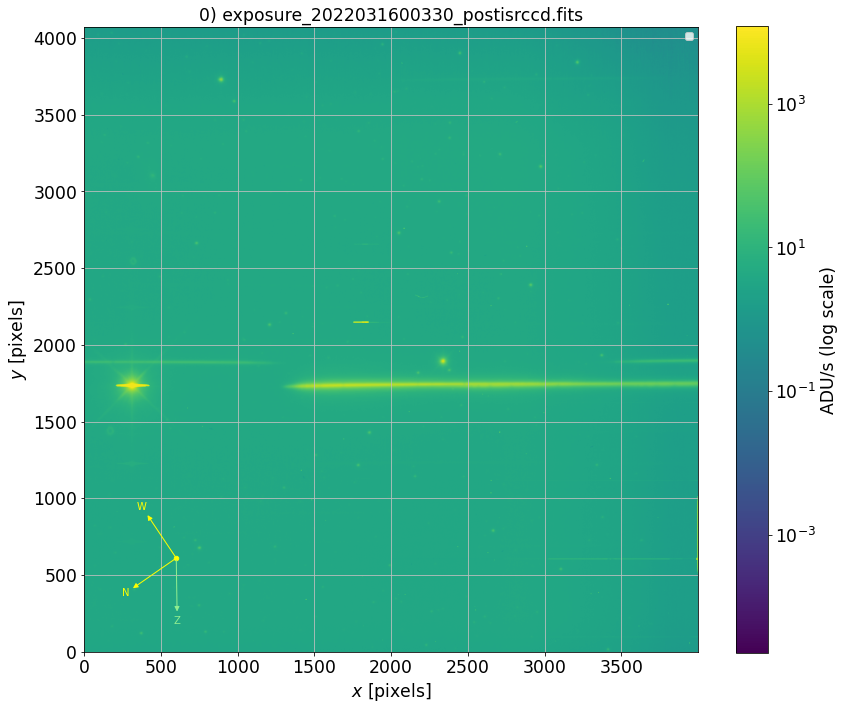

In [61]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [62]:
filename_image

'exposure_2022031600330_postisrccd.fits'

## Let Spectractor find the location of the 0th order

2022-07-10 18:54:29  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0               c0_1      
    ----------------- ------------------- -----------------
    6.885715301852011 0.04827591382585266 0.101968263560925


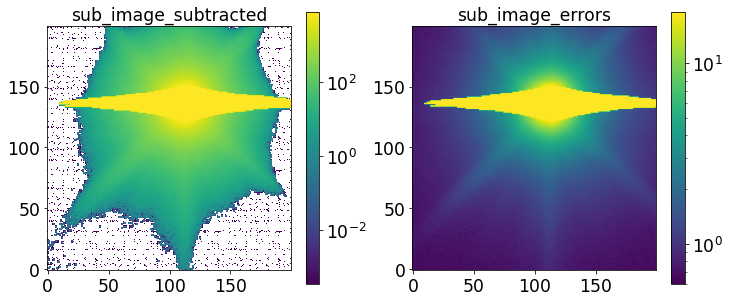

2022-07-10 18:54:31  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 11 iterations because the relative change of cost is below ftol=1.25e-05.


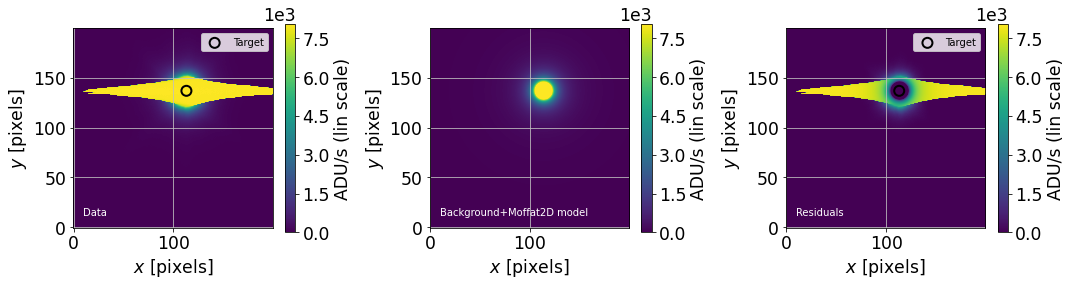

2022-07-10 18:54:32  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=5e-05.


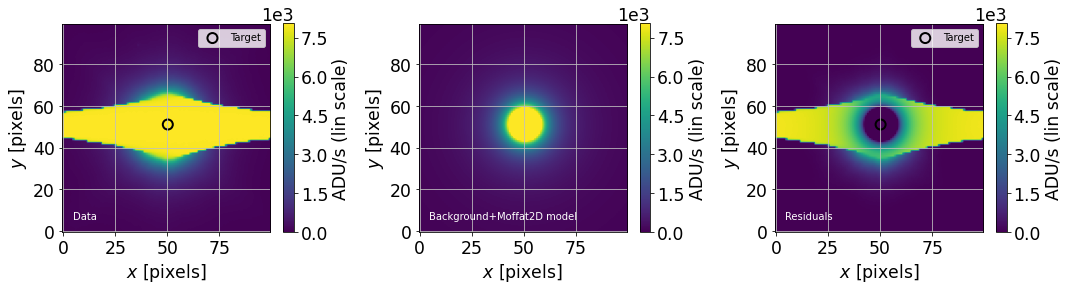

In [63]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [64]:
print(x1,y1)

313.2424612071033 1737.052172104784


## Check the location of 0th order and Analysis of the quality of its focus

In [65]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [66]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [67]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [68]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [69]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [70]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [71]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [72]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [73]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [74]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [75]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [76]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [77]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

Text(0.5, 0.98, '0) exposure_2022031600330_postisrccd.fits')

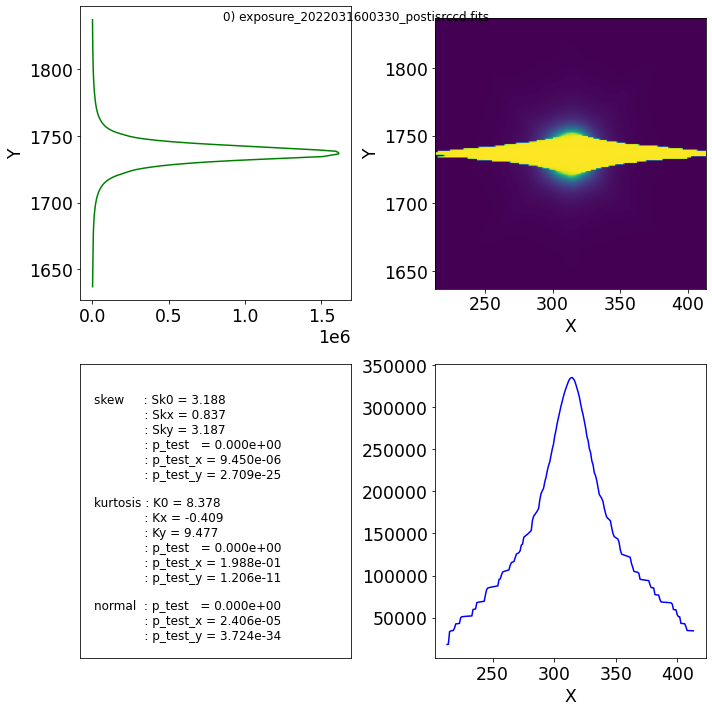

In [78]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title)

In [79]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [80]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

parameters.DEBUG=True
parameters.VERBOSE=True
parameters.DISPLAY=True
parameters.LIVE_FIT=False

In [81]:
filename

'/Users/dagoret/DATA/AuxTelData2022/data/2022/empty~holo4_003/20220316/exposure_2022031600330_postisrccd.fits'

In [82]:
output_directory

'./outputs_process_empty~holo4_003_config_DECONVOLUTION_FFM'

2022-07-10 18:54:34  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2022-07-10 18:54:34  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /Users/dagoret/DATA/AuxTelData2022/data/2022/empty~holo4_003/20220316/exposure_2022031600330_postisrccd.fits...
2022-07-10 18:54:34  Image      load_AUXTEL_image    INFO   
	Image loaded


No rebinning: parameters.REBIN is forced to 1.
Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /Users/dagoret/anaconda3/lib/python3.9/site-packages/Spectractor-2.1-py3.9.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /Users/dagoret/anaconda3/lib/python3.9/site-packages/Spectractor-2.1-py3.9.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: disperser	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: disperser	 <class 'str'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
x spectractor_deconvolution_sigma_clip: 100	=> parameters.SPECTRACTOR_

2022-07-10 18:54:35  Image      load_image           INFO   
	Loading disperser holo4_003...
2022-07-10 18:54:35  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /Users/dagoret/anaconda3/lib/python3.9/site-packages/Spectractor-2.1-py3.9.egg/spectractor/extractor/dispersers/holo4_003
2022-07-10 18:54:35  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2022-07-10 18:54:39  Star       load                 INFO   
	Simbad:
  MAIN_ID         RA           DEC      RA_PREC DEC_PREC ... PM_ERR_MINA_2 PM_ERR_ANGLE_2 Z_VALUE_2 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"                     ...    mas / yr        deg                                 
----------- ------------- ------------- ------- -------- ... ------------- -------------- --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635      14       14 ...         0.061             90 0.0000590                1


target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      RA_PREC DEC_PREC ... PM_ERR_MINA_2 PM_ERR_ANGLE_2 Z_VALUE_2 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"                     ...    mas / yr        deg                                 
----------- ------------- ------------- ------- -------- ... ------------- -------------- --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635      14       14 ...         0.061             90 0.0000590                1


2022-07-10 18:54:40  Star       load_spectra         INFO   
	Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/eta1dor_stis_002.fits


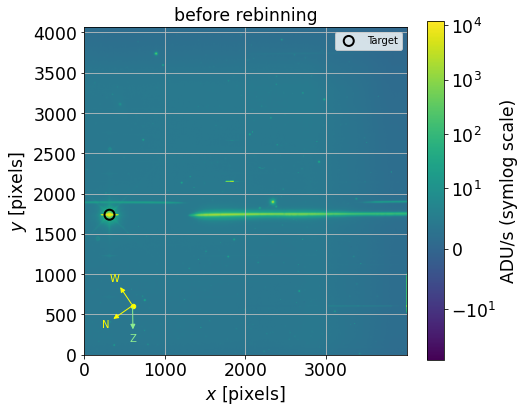

2022-07-10 18:54:44  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[ 313.24246121 1737.0521721 ]...
2022-07-10 18:54:44  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                 c1_0                   c0_1        
    ------------------ ---------------------- ---------------------
    23.729071360992368 -0.0004246717700631575 -0.014298387612732957


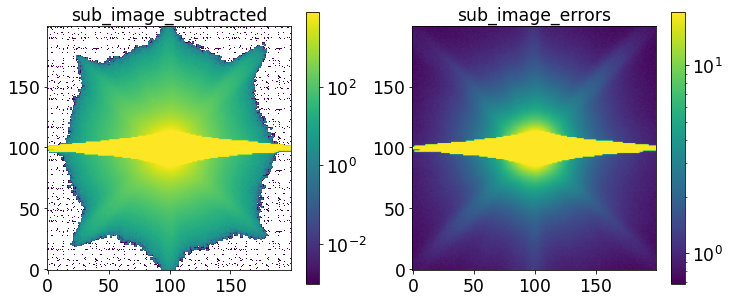

2022-07-10 18:54:45  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 18 iterations because the relative change of cost is below ftol=1.25e-05.


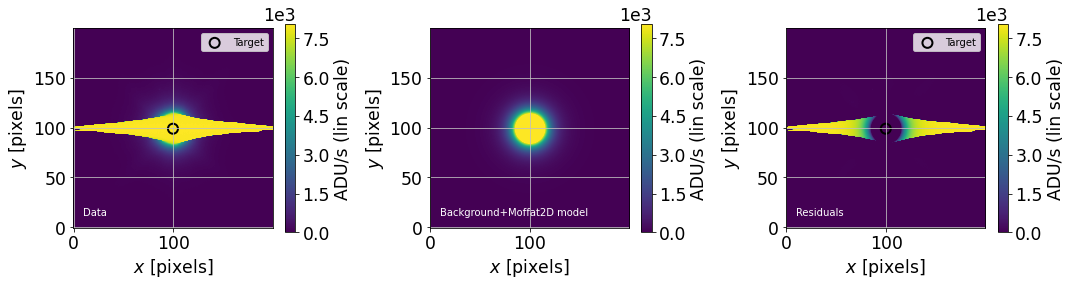

2022-07-10 18:54:46  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=5e-05.


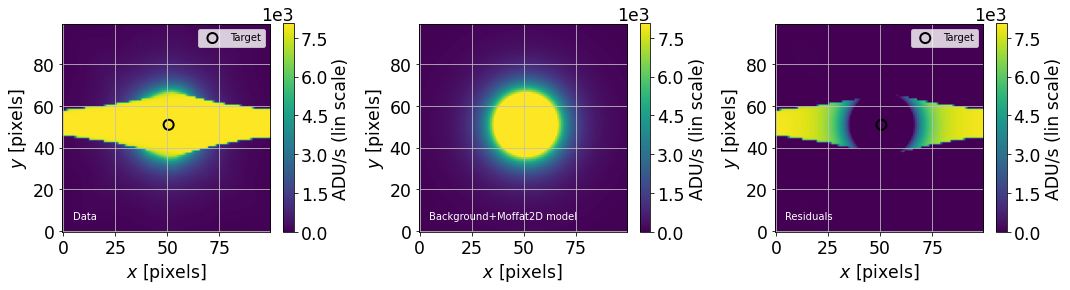

2022-07-10 18:54:47  Image      find_target          INFO   
	X,Y target position in pixels: 312.638,1735.924
2022-07-10 18:54:47  Image      turn_image           INFO   
	Rotate the image with angle theta=-0.28 degree


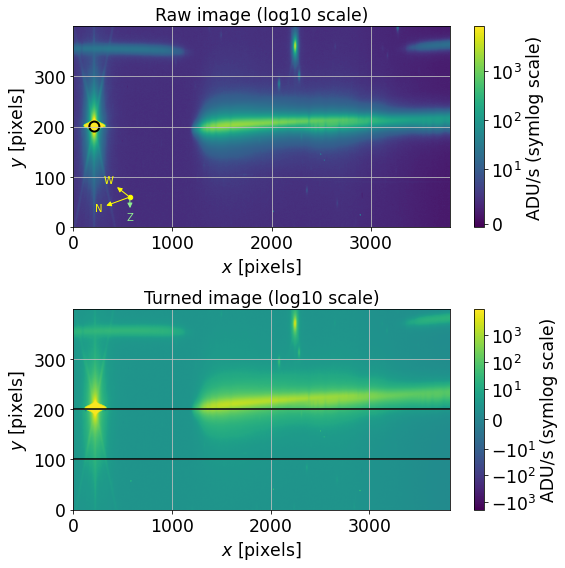

2022-07-10 18:55:02  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2022-07-10 18:55:02  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0               c0_1       
    ------------------ ------------------ ------------------
    1851.7083191696606 1.2759009069370726 2.2465170513921513


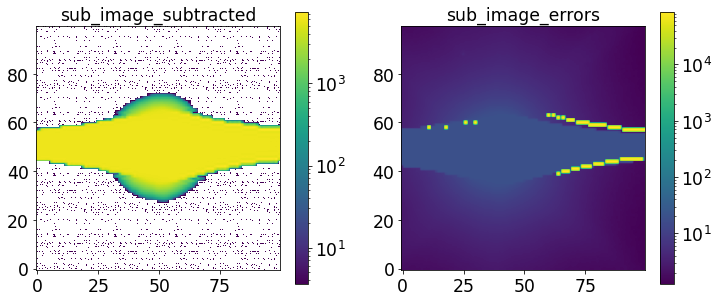

2022-07-10 18:55:03  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 12 iterations because the relative change of cost is below ftol=5e-05.


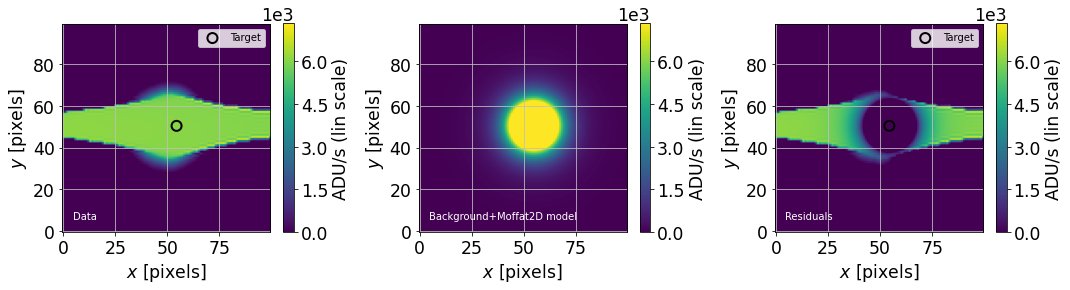

2022-07-10 18:55:04  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=0.0002.


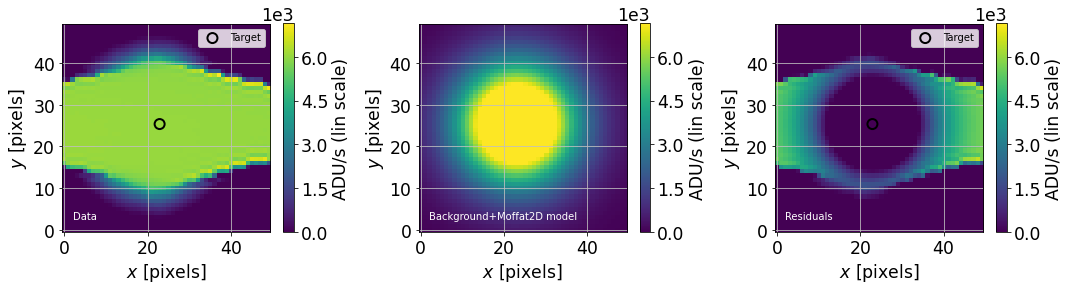

2022-07-10 18:55:04  Image      find_target          INFO   
	X,Y target position in pixels: 325.906,1737.387
2022-07-10 18:55:04  Spectrum   __init__             INFO   
	Spectrum info copied from image
2022-07-10 18:55:04  spectractor.extractor.extractor Spectractor          INFO   
	  ======================= PSF1D Extraction ====================================
2022-07-10 18:55:04  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= extract_spectrum_from_image =============================
2022-07-10 18:55:04  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*40 pixels and background from 140 to 180 pixels
2022-07-10 18:55:05  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [1174:3478,1557:1917] (size (2304, 360))


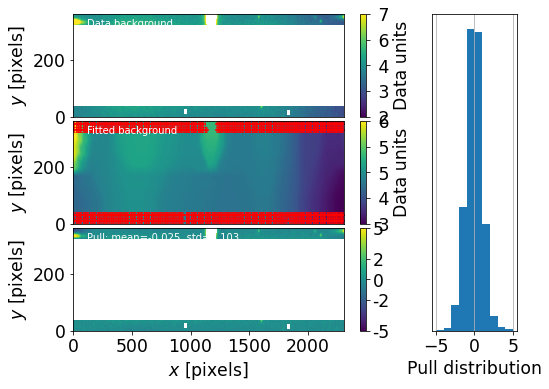

2022-07-10 18:55:08  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= Fit the transverse profile =============================
2022-07-10 18:55:08  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...
/Users/dagoret/anaconda3/lib/python3.9/site-packages/Spectractor-2.1-py3.9.egg/spectractor/extractor/psf.py:707: RuntimeWarning: invalid value encountered in true_divide
  out = evaluate_moffat1d_unnormalized(y, amplitude, y_c, gamma, alpha) / norm


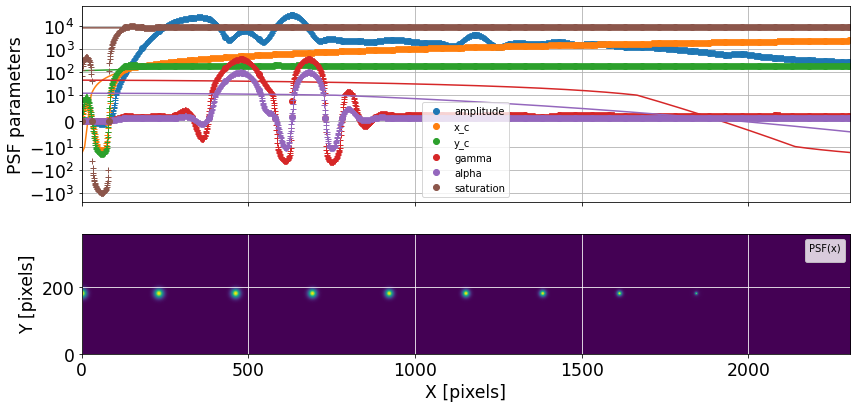

2022-07-10 18:55:16  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=3.0316e+08 initial chisq_red=1644.7
		 Line search: alpha_min=-0.301 iter=4 funcalls=8
	Parameter shifts: [  -0.19717984    0.3406624     1.2053918   -14.15956797  -81.00843463
 -152.13516428   -5.18760951  -36.07829479  -69.96677269]
	New parameters: [  -4.50577037  -17.15774857  -28.56258888  -28.55557846 -169.92157397
 -318.62062264   -8.24428316  -59.02049573 -112.95307319]
	Final cost=2.925e+08 final chisq_red=1586.9 computed in 1.84s
2022-07-10 18:55:18  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=2.925e+08 initial chisq_red=1586.9
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [  0.68453019  -1.62681266  -5.03048948 -11.70526131 -16.76389934
  -7.07853027 -27.8165456  -50.08844204 -44.56412693]
	New parameters: [  -3.82124018  -18.78456123  -33.59307836  -40.26083977 -186.68547331
 -325.69915291  -36.06082876 -109.10893778 -157.

2022-07-10 18:55:43  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=16: initial cost=1.4113e+08 initial chisq_red=765.7
		 Line search: alpha_min=1.83 iter=0 funcalls=5
	Parameter shifts: [ 0.47078916 -0.12128571 -0.63465317  1.70938349 -1.0623136  -2.99787507
  1.47553348  2.56569267  3.94492019]
	New parameters: [   7.14707103   -0.31381717  -19.73632262    6.48876716 -118.32638495
 -216.74090658  -10.41529323  -91.03270362 -155.77239905]
	Final cost=1.3733e+08 final chisq_red=745.09 computed in 1.72s
2022-07-10 18:55:45  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=17: initial cost=1.3733e+08 initial chisq_red=745.09
		 Line search: alpha_min=3.13 iter=0 funcalls=6
	Parameter shifts: [0.17816575 1.25868416 1.71438645 3.11295921 6.17036813 8.7897091
 2.38215456 2.36688197 2.07512754]
	New parameters: [   7.32523678    0.94486698  -18.02193617    9.60172637 -112.15601682
 -207.95119748   -8.03313867  -88.66582165 -153.69727151]
	Final cost=1.3343e+08 

2022-07-10 18:56:13  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=32: initial cost=9.8916e+07 initial chisq_red=536.66
		 Line search: alpha_min=1.62 iter=1 funcalls=5
	Parameter shifts: [ 0.39332554 -0.34078099  0.34898868  1.40965664  0.53845168  1.55988837
  0.79596108  1.16113198  1.88458046]
	New parameters: [  10.54091573    5.57256756  -13.73894873   35.07987043  -84.60354982
 -162.83748452   11.41722548  -64.79957182 -120.29787287]
	Final cost=9.7217e+07 final chisq_red=527.43 computed in 1.77s
2022-07-10 18:56:15  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=33: initial cost=9.7217e+07 initial chisq_red=527.43
		 Line search: alpha_min=2.28 iter=0 funcalls=5
	Parameter shifts: [-0.13797772  0.67852288  0.02685209  1.19001419  1.99947718  2.93124944
  1.22364852  1.1647024   2.02613212]
	New parameters: [  10.40293801    6.25109044  -13.71209664   36.26988462  -82.60407264
 -159.90623507   12.64087399  -63.63486942 -118.27174075]
	Final cost=

2022-07-10 18:56:39  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=48: initial cost=7.4465e+07 initial chisq_red=404
		 Line search: alpha_min=1.62 iter=1 funcalls=5
	Parameter shifts: [ 0.26727417 -0.25453794  0.26095552  0.68599874  1.21058198  1.05122972
  0.20408269  1.1844542   0.34553252]
	New parameters: [  12.170012      8.52939711  -10.72181632   60.85602782  -75.01642382
 -118.0518556    31.30130409  -53.35157303  -71.76154619]
	Final cost=7.3402e+07 final chisq_red=398.23 computed in 1.56s
2022-07-10 18:56:41  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=49: initial cost=7.3402e+07 initial chisq_red=398.23
		 Line search: alpha_min=2.81 iter=0 funcalls=6
	Parameter shifts: [-1.29119297e-01  5.55841141e-01  1.83141168e-03  1.01835287e+00
  2.17496636e+00  1.92428649e+00  1.02853423e+00  8.90860472e-01
  1.52639925e+00]
	New parameters: [  12.04089271    9.08523825  -10.71998491   61.87438069  -72.84145746
 -116.1275691    32.32983832  -52.46

	 >>>>> cov =  [[ 6.05774423e-08 -4.54071077e-08  2.86589238e-08  2.18107834e-08
  -3.35766677e-09 -9.23674766e-08  7.90457887e-09 -1.83826012e-08
  -8.23698440e-08]
 [-4.54071077e-08  2.56526123e-07 -2.33134814e-07  3.49307455e-08
   2.32376423e-08 -2.01451173e-07 -1.72008364e-08  1.86842241e-08
  -1.31383048e-07]
 [ 2.86589238e-08 -2.33134814e-07  6.06848438e-07 -8.57426112e-08
   1.19540324e-08  6.01821809e-07  5.34192060e-09  5.77030045e-09
   4.54154431e-07]
 [ 2.18107834e-08  3.49307455e-08 -8.57426112e-08  5.36835119e-05
  -7.69287545e-05 -5.10401677e-05  1.11550828e-05 -1.21058250e-05
   1.10608331e-05]
 [-3.35766677e-09  2.32376423e-08  1.19540324e-08 -7.69287545e-05
   1.33440779e-04  1.25025280e-05 -1.84274107e-05  2.63886745e-05
  -4.64605892e-05]
 [-9.23674766e-08 -2.01451173e-07  6.01821809e-07 -5.10401677e-05
   1.25025280e-05  6.26420101e-04  9.06031403e-06 -4.02195152e-05
   2.02567455e-04]
 [ 7.90457887e-09 -1.72008364e-08  5.34192060e-09  1.11550828e-05
  -1.84274107

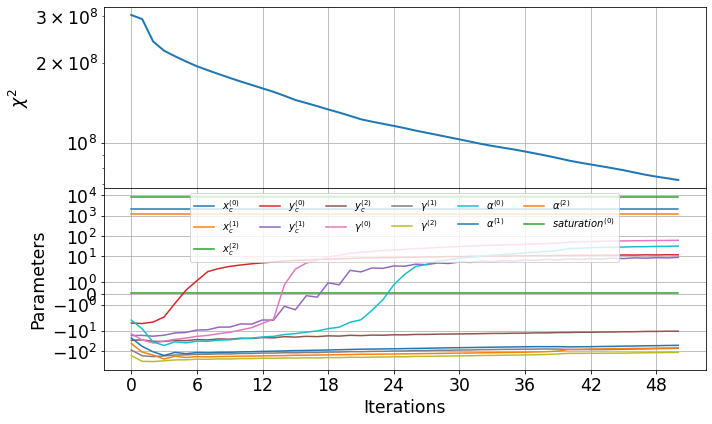

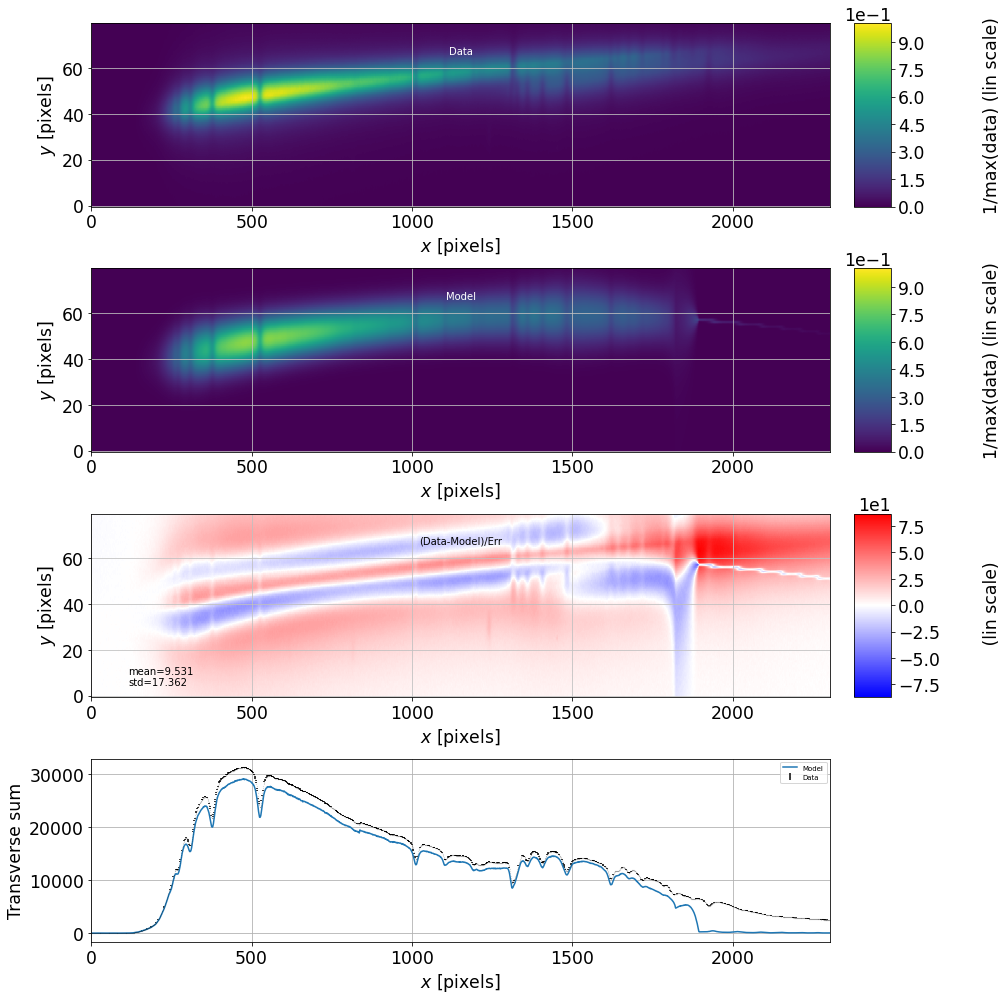

2022-07-10 18:56:45  ChromaticPSF1DFitWorkspace plot_correlation_matrix INFO   Save figure ./figures_process_empty~holo4_003_config_DECONVOLUTION_FFM/parameters_correlation.pdf.


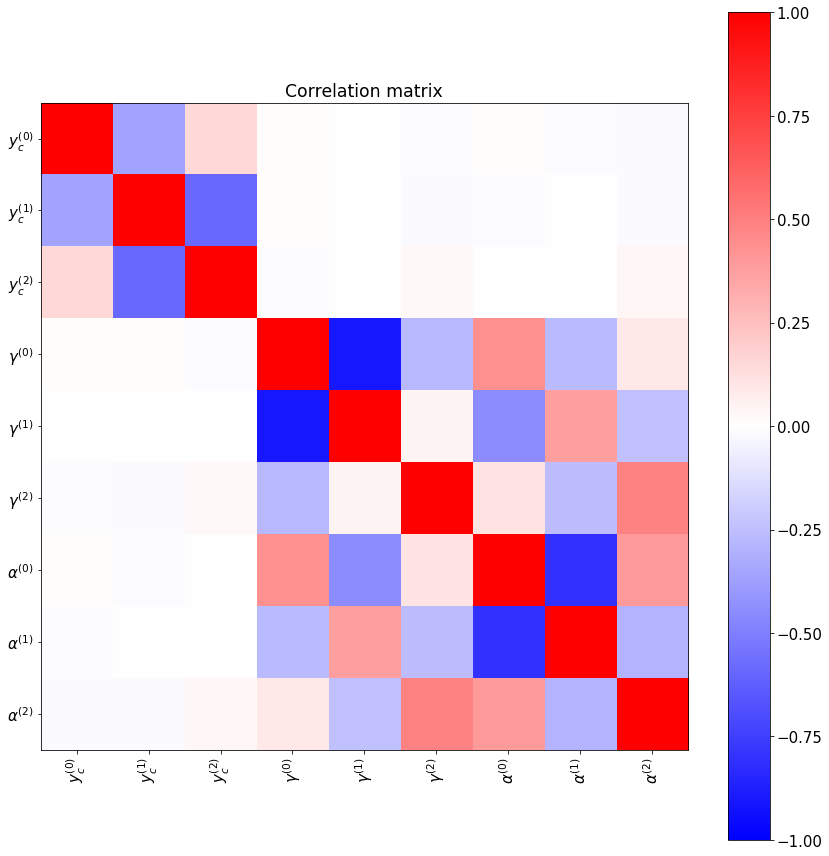

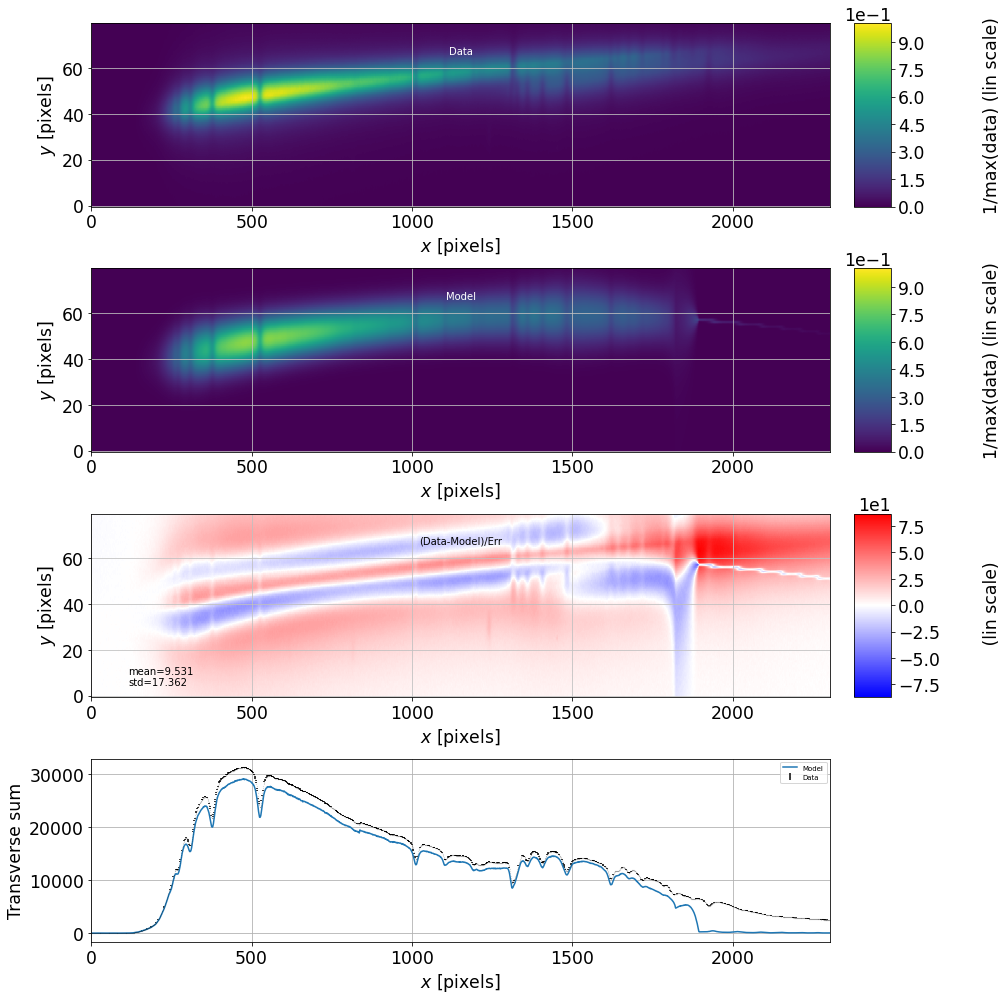

2022-07-10 18:56:52  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop raw image [1160:3464,1540:1912] (size (2304, 372))
2022-07-10 18:56:52  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= Extract the non rotated background  =============================


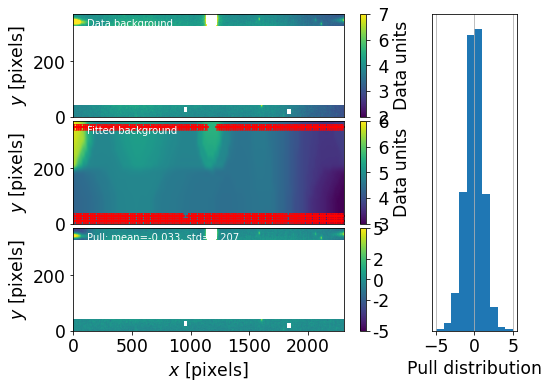

2022-07-10 18:56:54  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=4.368 ADU/s, RMS=0.637 ADU/s.
2022-07-10 18:56:54  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= first guess for lambdas  =============================
2022-07-10 18:56:54  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [1160:3464,1540:1912] (size (2304, 372))
	New target position in spectrogram frame: [-847.362084484808, 195.92378265091543]


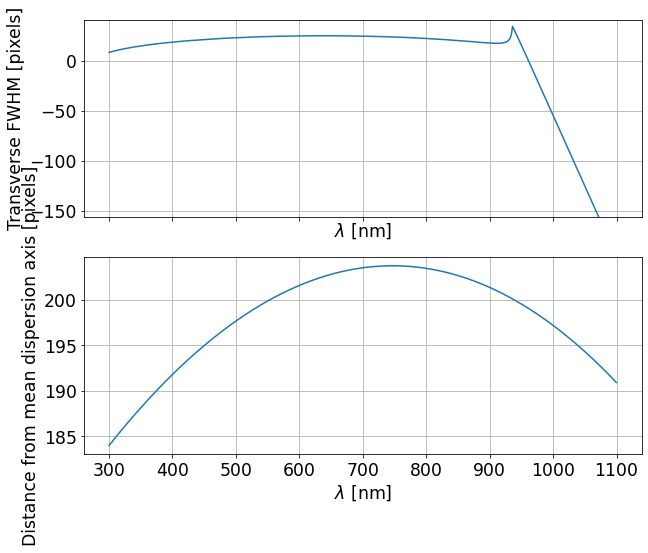

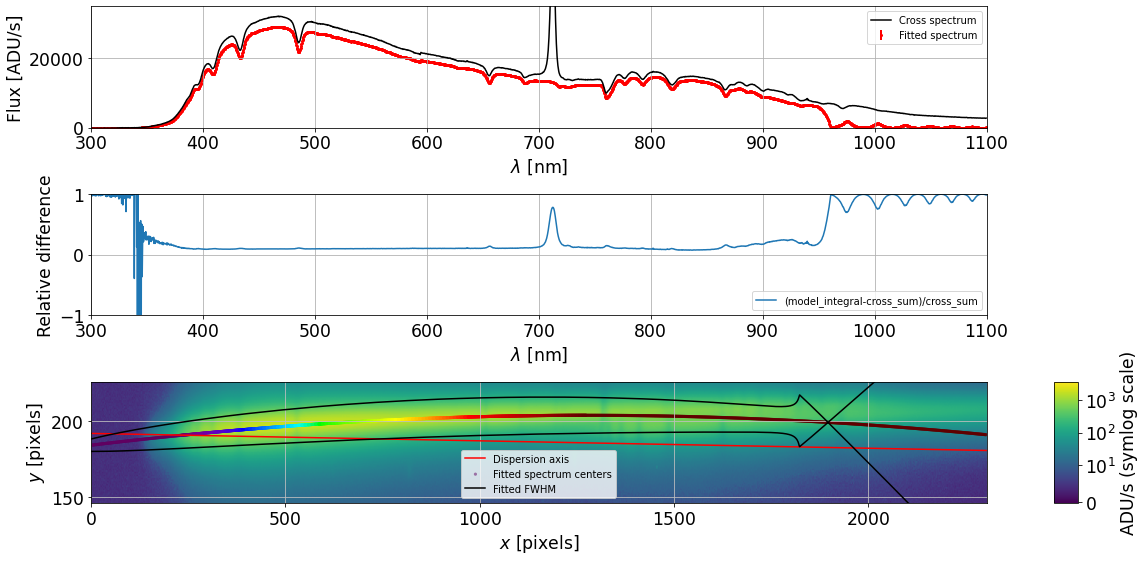

2022-07-10 18:56:57  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


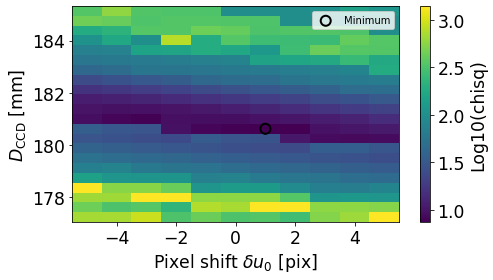

2022-07-10 18:57:32  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.436pix
	D = 180.818 mm (default: DISTANCE2CCD = 181.00 +/- 0.75 mm, -0.2 sigma shift)
2022-07-10 18:57:32  spectractor.extractor.extractor Spectractor          INFO   
	  ======================= FFM DECONVOLUTION =============================
2022-07-10 18:57:39  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=1.
2022-07-10 18:57:41  spectractor.extractor.extractor run_ffm_minimisation INFO   
 --- Start FFM with adjust_spectrogram_position_parameters --- 
2022-07-10 19:03:19  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=5.2428e+08 initial chisq_red=3122.5
		 Line search: alpha_min=1.9 iter=0 funcalls=5
	Parameter shifts: [33.51227132 -0.67202461]
	New parameters: [33.51227132 -0.95202461]
	Final cost=3.2126e+08 final chisq_red=1913.3 computed in 288.11s
2022-07-10 19:07:59  spectractor.fit.fitter gr

	 >>>>> cov =  [[ 1.69661650e-06 -3.51008769e-08]
 [-3.51008769e-08  7.36668603e-10]] >>>>  cov.shape =  (2, 2)


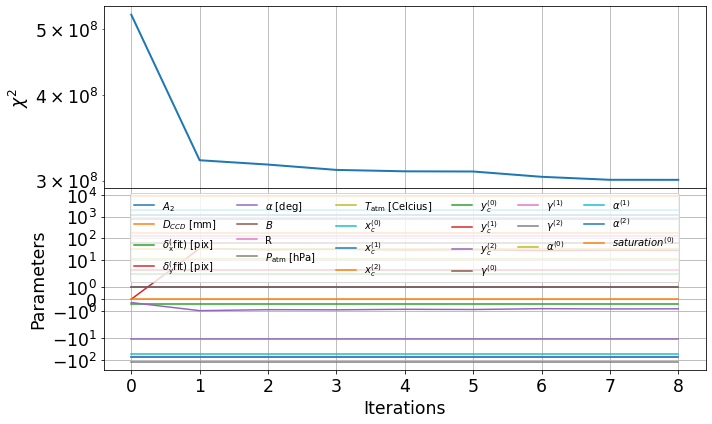

2022-07-10 19:38:51  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_empty~holo4_003_config_DECONVOLUTION_FFM/ffm_bestfit.pdf.
2022-07-10 19:38:53  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_empty~holo4_003_config_DECONVOLUTION_FFM/ffm_bestfit_2.pdf.


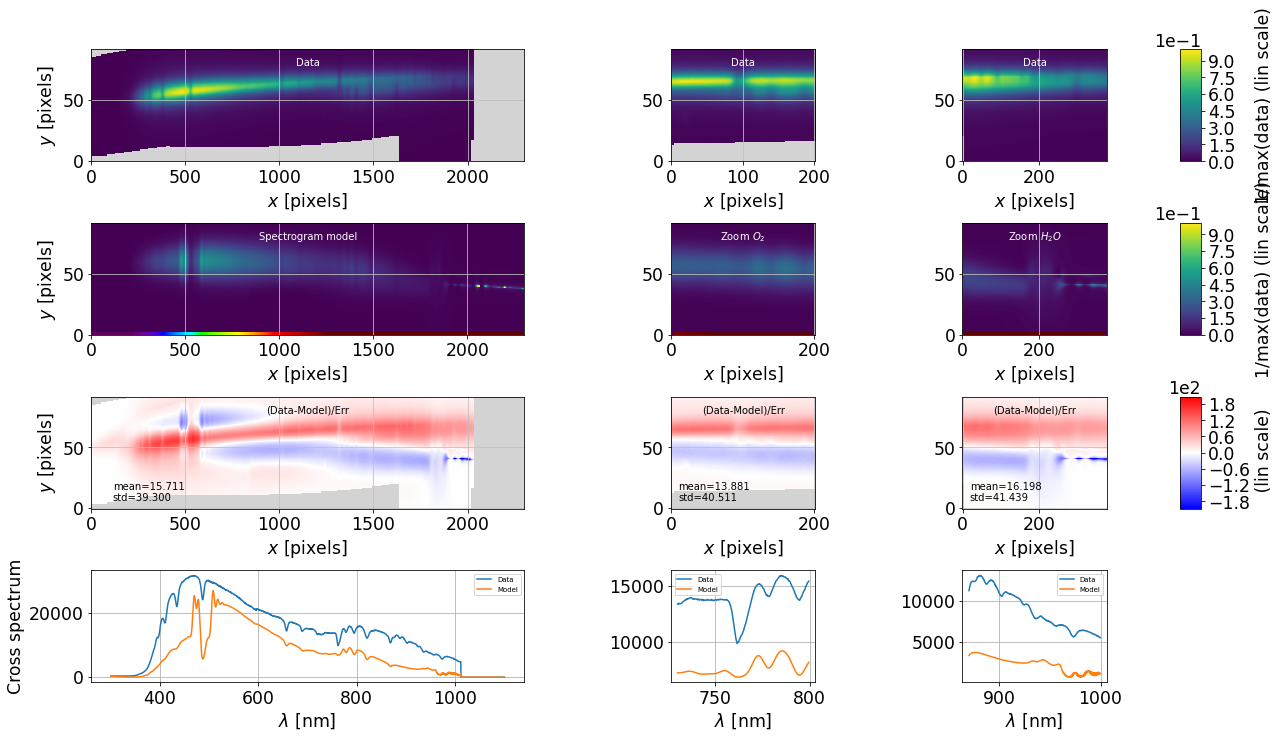

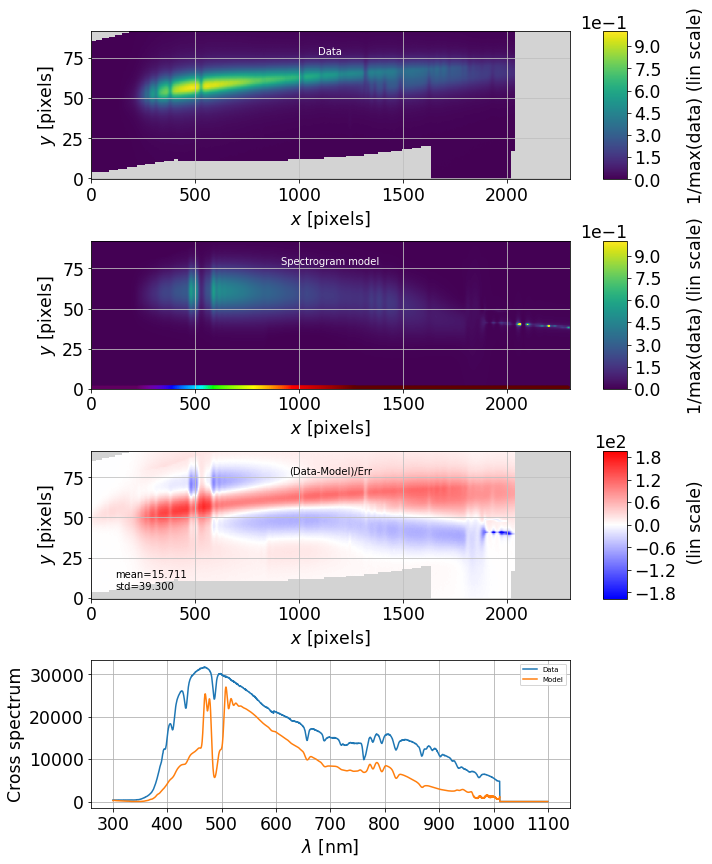

2022-07-10 19:38:55  FullForwardModelFitWorkspace plot_correlation_matrix INFO   Save figure ./figures_process_empty~holo4_003_config_DECONVOLUTION_FFM/parameters_correlation.pdf.


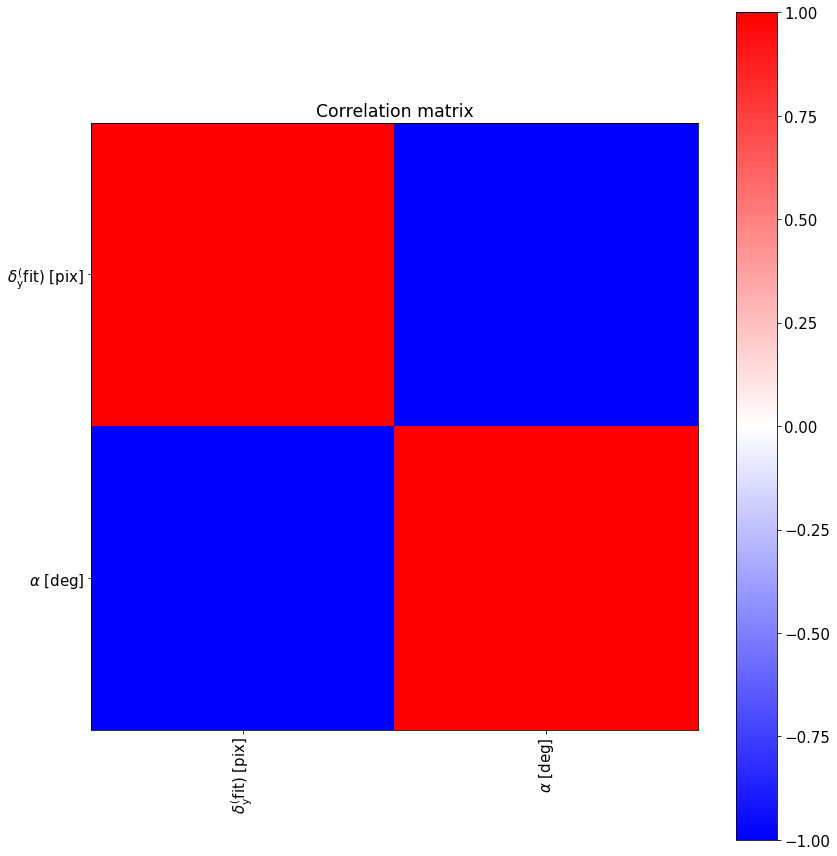

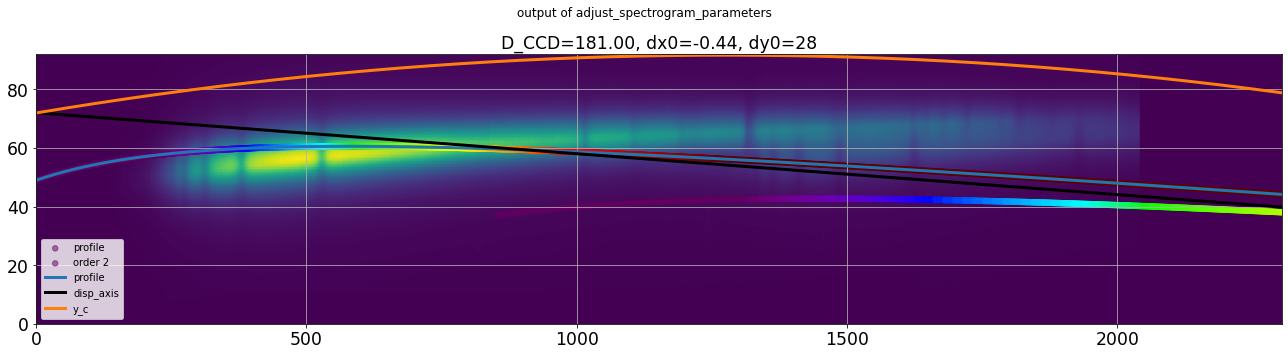

2022-07-10 19:39:39  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_empty~holo4_003_config_DECONVOLUTION_FFM/ffm_bestfit.pdf.
2022-07-10 19:39:41  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_empty~holo4_003_config_DECONVOLUTION_FFM/ffm_bestfit_2.pdf.


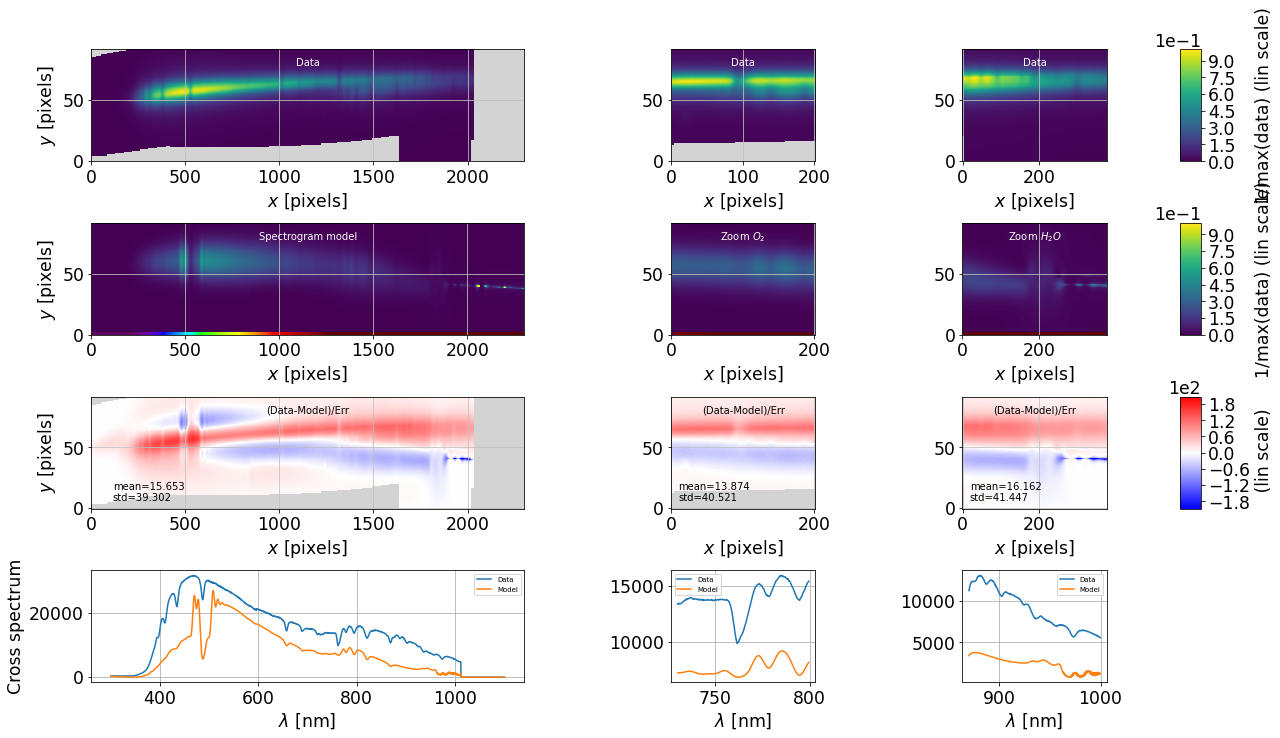

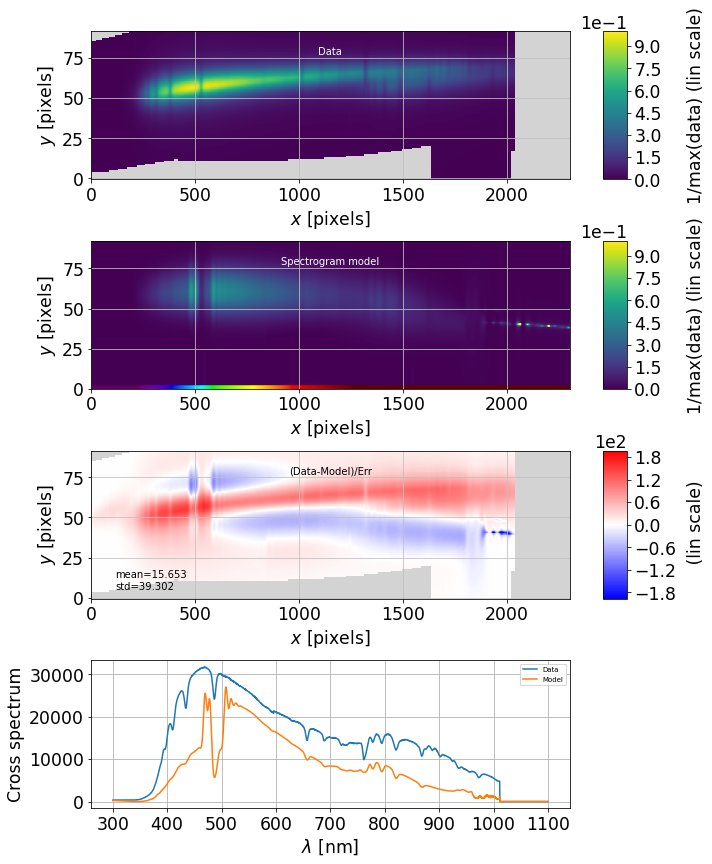

2022-07-10 19:39:43  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start guess: [ 1.00000000e+00  1.80818469e+02 -4.36270554e-01  2.79348574e+01
 -8.00413366e-01  1.00000000e+00  1.24293446e+02  7.43550000e+02
  1.06000000e+01  1.99957017e+03  1.15148625e+03 -9.29201239e-16
  2.26892789e+00  3.45786159e+00 -1.07198569e+01  6.19783651e+01
 -7.26674325e+01 -1.15892799e+02  3.26536944e+01 -5.19101599e+01
 -6.95529015e+01  8.50027171e+03]
	with ['A2', 'D_CCD [mm]', 'shift_x [pix]', 'shift_y [pix]', 'angle [deg]', 'B', 'R', 'P [hPa]', 'T [Celsius]', 'x_c_0', 'x_c_1', 'x_c_2', 'y_c_0', 'y_c_1', 'y_c_2', 'gamma_0', 'gamma_1', 'gamma_2', 'alpha_0', 'alpha_1', 'alpha_2', 'saturation_0']
2022-07-10 19:39:43  spectractor.extractor.extractor run_ffm_minimisation INFO   
 --- before  run_minimisation ---
2022-07-10 19:39:43  spectractor.extractor.extractor dumpfitparameters    INFO   

- fit param #0 :: A2 = 1.0 	 fixed = True 	 bounds 0.000 - 20.000
- fit param #1 :: D_CCD [mm] = 1

2022-07-10 21:24:26  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=10: initial cost=1.2505e+08 initial chisq_red=744.79
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 1.12133634e-01  2.93131599e-03 -1.15644364e+01 -1.71469153e+00
  2.51425594e+00 -7.02524264e-01  2.18870083e-01 -6.51536804e-01
 -2.15620427e-01]
	New parameters: [  21.176777     -0.47244253 -100.           64.61638343 -105.04249862
   39.04017494   74.68062744 -135.86159741   92.89007838]
	Final cost=1.2316e+08 final chisq_red=733.5 computed in 535.02s
2022-07-10 21:34:44  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=11: initial cost=1.2316e+08 initial chisq_red=733.5
		 Line search: alpha_min=0.259 iter=4 funcalls=8
	Parameter shifts: [-1.49435161e-02  2.05978366e-03 -3.50515082e+00 -3.93266733e-01
  5.37123607e-01  8.03968371e-01 -1.82807965e+00  3.41739628e+00
 -2.37981978e+00]
	New parameters: [  21.16183348   -0.47038275 -100.           64.2231167  -104.5053750

In [ ]:
if FLAG_RUNWITHEXCEPTIONS:
    try:
        spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)
    except:
        errtype = sys.exc_info()[0]  # E.g. <class 'PermissionError'>
        description = sys.exc_info()[1]   # E.g. [Errno 13] Permission denied: ...
        
        print("\t +++++++++++++++++++++ Exception occured +++++++++++++++++++++++++++++++++++++++++")
        print(f"\t >>>>>  errtype = {errtype}")
        print(f"\t >>>>>> description = {description}")
else:
    spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

In [ ]:
spectrum.plot_spectrum(force_lines=True) 

# Backup output

- If no crash occurs, arrive here

./outputs_process_holo_config_DECONVOLUTION_PSF2D

In [ ]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [ ]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    
    if not os.path.isdir(path_toptoptopoutput_spectractor):
        os.mkdir(path_toptoptopoutput_spectractor)
    
    if not os.path.isdir(path_toptopoutput_spectractor):
        os.mkdir(path_toptopoutput_spectractor) 
        
    if configdir !="":
    # top directory    
        if not os.path.isdir(path_topoutput_spectractor):
            os.mkdir(path_topoutput_spectractor)   
            
            
        if not os.path.isdir(path_output_spectractor):
            os.mkdir(path_output_spectractor)
  
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
print("******************************** SUCCESS ********************************************")

In [ ]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

In [ ]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
print("finalpath_output_spectractor = ",finalpath_output_spectractor)

In [ ]:
os.listdir(os.path.join(finalpath_output_spectractor,"basespec"))

In [ ]:
os.listdir(os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
output_directory